## Extracting variables from BARRA-R2 for specific locations
Detailed description of paramters here: https://opus.nci.org.au/spaces/NDP/pages/338002591/BARRA2+Parameter+Descriptions 

In [1]:
import xarray as xr
import os
import sys
import dask.distributed
import glob
from dask.distributed import Client
import tempfile
import dask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Dask settings
dask.config.set({
    #'array.chunk-size': "256 MiB",
    #'array.slicing.split_large_chunks': True, 
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39793,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:46047,Total threads: 1
Dashboard: /proxy/34923/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:36377,


2025-03-07 16:06:26,230 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39139'.
2025-03-07 16:06:26,233 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43151'.
2025-03-07 16:06:26,234 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37905'.
2025-03-07 16:06:26,235 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46047'.
2025-03-07 16:06:26,236 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37487'.
2025-03-07 16:06:26,237 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37095'.
2025-03-07 16:06:26,238 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40025'.
2025-03-07 16:06:26,240 - distributed.scheduler - WARNING - Received heartbeat from unregistered 

In [3]:
####< Functions
# Function to compute great-circle distance using NumPy (vectorised)
def great_circle_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in km
    

In [4]:
HOURLY_FREQ = False

In [28]:
freq = "1hr" if HOURLY_FREQ else "day"

barra_dir = f"/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/{freq}/"
out_dir = "/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/"
barra_sftlf = xr.open_dataset(f"/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/sftlf/latest/sftlf_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc").sftlf

In [45]:
hist_start = "1980" # QME BARRA correction uses 1980-2022
hist_end = "2022"

locations = {'Darwin':{'Lat':-12.42,'Lon':130.89,'Elev':30}, # BOM station: 014015
             'Cairns':{'Lat':-16.87,'Lon':145.75,'Elev':2}, # BOM station: 031011
             'Brisbane':{'Lat':-27.48,'Lon':153.04,'Elev':8}, # BOM station: 040913
             'Longreach':{'Lat':-23.44,'Lon':144.28,'Elev':192}, # BOM station: 036031
             'Mildura':{'Lat':-34.23,'Lon':142.09,'Elev':50}, # BOM station: 076031
             'Adelaide':{'Lat':-34.95,'Lon':138.51,'Elev':2}, # BOM station: 023034
             'Perth':{'Lat':-31.92,'Lon':115.87,'Elev':25}, # BOM station: 009225
             'Sydney':{'Lat':-33.86,'Lon':151.20,'Elev':39}, # BOM stations: 066062/066214
             'Melbourne':{'Lat':-37.81,'Lon':144.97,'Elev':31}, # BOM stations: 086071/086338
             'Canberra':{'Lat':-35.31,'Lon':149.19,'Elev':577}, # BOM station: 070351
             'Hobart':{'Lat':-42.89,'Lon':147.33,'Elev':51}, # BOM station: 094029
             'Thredbo':{'Lat':-36.50,'Lon':148.29,'Elev':1380}} # BOM station: 071041

barra_vars = {'temperature':['tas'],
              'humidity_relative':['hurs'],
              'humidity_specific':['huss'],
              'pressure':['psl'],
              'wind_speed_10m':['sfcWind'],
              'wind_direction_u':['uas'],
              'wind_direction_v':['vas'],
              'cloud_cover':['clt'],
              'solar_global':['rsds'], #  Its direct component has not accounted for the solar zenith angle. This parameter can be treated as an estimate of global horizontal irradiance (GHI).
              'solar_diffuse':['rsdsdif'], # The parameter has been corrected for the solar zenith angle.
              'solar_direct':['rsdsdir']}  # The parameter has been corrected for the solar zenith angle and the effect of topography.

In [46]:
# Extract grid information
latitudes = barra_sftlf['lat'].values
longitudes = barra_sftlf['lon'].values
valid_mask = barra_sftlf.values >= 90  # Mask where terrain fraction is at least 90

# Get valid lat/lon pairs
valid_lats, valid_lons = np.meshgrid(latitudes, longitudes, indexing='ij')  # Ensure correct shape
valid_lats, valid_lons = valid_lats[valid_mask], valid_lons[valid_mask]  # Apply mask

# Find the closest valid grid cell for each location & store in a new dictionary
updated_locations = {}
for name, info in locations.items():
    lat, lon, elev = info['Lat'], info['Lon'], info['Elev']
    distances = great_circle_distance(lat, lon, valid_lats, valid_lons)
    
    min_idx = np.argmin(distances)  # Index of closest point
    new_lat, new_lon = valid_lats[min_idx], valid_lons[min_idx]
    
    updated_locations[name] = {'Lat': new_lat, 'Lon': new_lon, 'Elev': elev}  # Preserve elevation


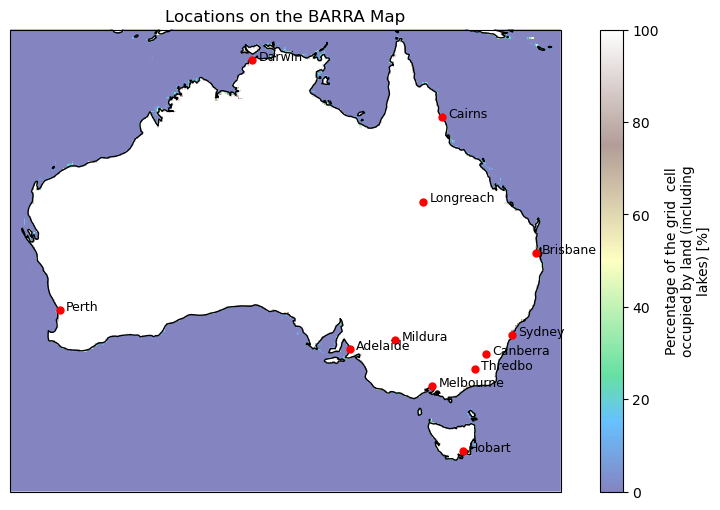

In [70]:
# Create a plot with Cartopy
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the background data (assumes barra_sftlf is a 2D xarray DataArray)
barra_sftlf.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="terrain", alpha=0.6)

# Add geographical features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot locations with red dots and labels
for name, info in locations.items():
    ax.plot(info['Lon'], info['Lat'], 'ro', markersize=5, transform=ccrs.PlateCarree())  # Red dots
    ax.text(info['Lon'] + 0.5, info['Lat'], name, fontsize=9, transform=ccrs.PlateCarree())

# Set the extent (optional: adjust for better visibility)
ax.set_extent([112, 155, -44, -10])  # Adjust based on your data
ax.set_label("Land Fraction (%)")

# Show the map
plt.title("Locations on the BARRA Map")
plt.show()

/jobfs/136616129.gadi-pbs/ipykernel_1111323/3463616377.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


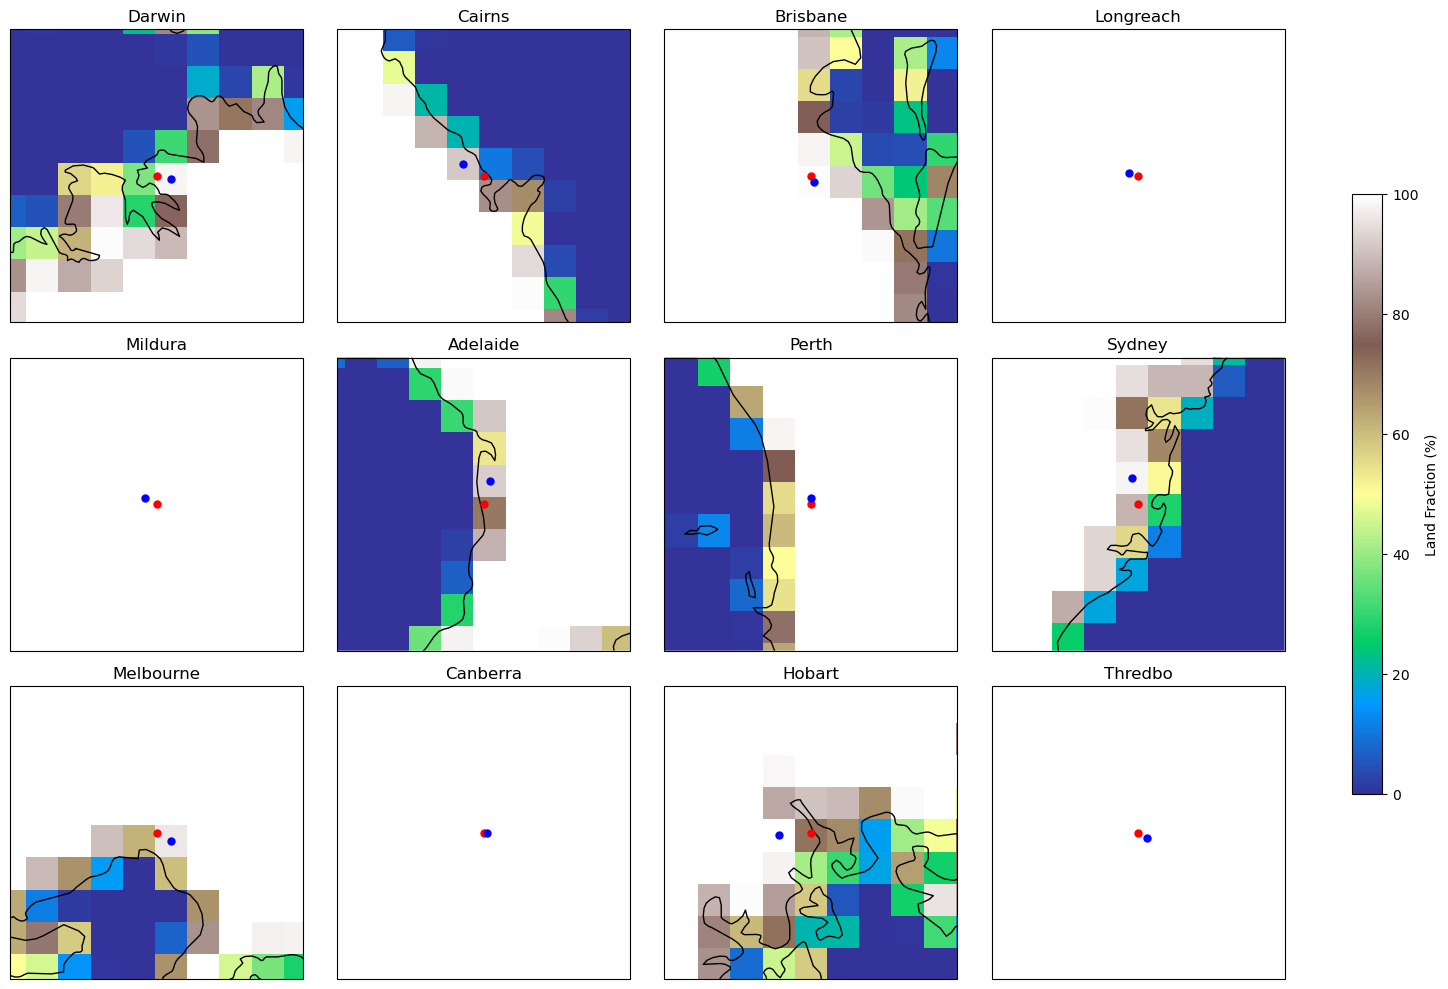

In [47]:
# Find the closest valid grid cell for each location
closest_points = {}
for name, info in locations.items():
    lat, lon = info['Lat'], info['Lon']
    distances = great_circle_distance(lat, lon, valid_lats, valid_lons)
    
    min_idx = np.argmin(distances)  # Index of closest point
    closest_points[name] = (valid_lats[min_idx], valid_lons[min_idx])

# Create facet plot
num_locs = len(locations)
cols = 4  # Number of columns in facet grid
rows = int(np.ceil(num_locs / cols))  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten for easy iteration

# Get colorbar limits
vmin, vmax = barra_sftlf.min(), barra_sftlf.max()

for ax, (name, info) in zip(axes, locations.items()):
    # ax.set_title(name)

    # Define zoomed extent
    zoom_factor = 0.5  # Adjust zoom level (higher = less zoom)
    lat, lon = info['Lat'], info['Lon']
    lat_range = (lat - zoom_factor, lat + zoom_factor)
    lon_range = (lon - zoom_factor, lon + zoom_factor)
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())

    # Plot land fraction map
    im = barra_sftlf.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="terrain", vmin=vmin, vmax=vmax, add_colorbar=False)
    
    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot original location (red)
    ax.plot(info['Lon'], info['Lat'], 'ro', markersize=5, transform=ccrs.PlateCarree(), label="Original Location")
    
    # Plot adjusted location (blue)
    if closest_points[name] != (None, None):
        ax.plot(closest_points[name][1], closest_points[name][0], 'bo', markersize=5, transform=ccrs.PlateCarree(), label="Closest Valid Cell")

    # Add a title with the location name
    ax.set_title(name, fontsize=12)
    
# Remove empty subplots if any
for i in range(num_locs, len(axes)):
    fig.delaxes(axes[i])

# Add single colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Land Fraction (%)")

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar

# Show figure
plt.show()

In [ ]:
%%time
for loc in updated_locations:
    print(loc)
    out_file = f"{out_dir}{loc}_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_{freq}_{hist_start}-{hist_end}.nc"

    if os.path.exists(out_file)==False:
        var_list = []
        var_name_list = []   
        def _preprocess(ds):
            return ds.sel(lat=updated_locations[loc]['Lat'],
                          lon=updated_locations[loc]['Lon'],
                          method = "nearest").sel(time=slice(f'{hist_start}-01-01',f'{hist_end}-12-31'))
    
        for var in barra_vars:
            # diffuse solar radiation does not exist in day data
            if var == 'solar_diffuse' and freq == 'day':
                continue
            varn = barra_vars[var]
            print(f"{var}: {varn}")
            
            file_list = glob.glob(f"{barra_dir}/{varn[0]}/latest/{varn[0]}_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_{freq}_*.nc")
            file_list = sorted(list(set([f for f in file_list for y in list(range(int(hist_start), int(hist_end)+1)) if f"{y}" in f])))
            print(len(file_list), len(list(range(int(hist_start), int(hist_end)+1)))*12)
            
            da = xr.open_mfdataset(file_list,combine='nested',concat_dim='time',parallel=True,preprocess=_preprocess)[varn[0]].chunk({'time':-1})
            var_list.append(da.to_dataset())
            var_name_list.append(var)
    
        var_list = [da.drop_vars(["bnds","height","level_height","model_level_number","sigma"], errors="ignore") for da in var_list]
    
        da_var = xr.merge(var_list)
        da_var.to_netcdf(out_file)
    else:
        print(f'File for {loc} exists in output directory.')

Darwin
temperature: ['tas']
516 516
humidity_relative: ['hurs']
516 516
humidity_specific: ['huss']
516 516
pressure: ['psl']
516 516
wind_speed_10m: ['sfcWind']
516 516
wind_direction_u: ['uas']
516 516
wind_direction_v: ['vas']
516 516
cloud_cover: ['clt']
516 516
solar_global: ['rsds']
516 516
solar_direct: ['rsdsdir']
516 516


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Cairns
temperature: ['tas']
516 516
humidity_relative: ['hurs']
516 516
humidity_specific: ['huss']
516 516
pressure: ['psl']
516 516
wind_speed_10m: ['sfcWind']
516 516
wind_direction_u: ['uas']
516 516
wind_direction_v: ['vas']
516 516
cloud_cover: ['clt']
516 516
solar_global: ['rsds']
516 516
solar_direct: ['rsdsdir']
516 516


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Brisbane
temperature: ['tas']
516 516
humidity_relative: ['hurs']
516 516
humidity_specific: ['huss']
516 516
pressure: ['psl']
516 516
wind_speed_10m: ['sfcWind']
516 516
wind_direction_u: ['uas']
516 516
wind_direction_v: ['vas']
516 516
cloud_cover: ['clt']
516 516
solar_global: ['rsds']
516 516
solar_direct: ['rsdsdir']
516 516


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Longreach
temperature: ['tas']
516 516
humidity_relative: ['hurs']
516 516
humidity_specific: ['huss']
516 516
pressure: ['psl']
516 516
wind_speed_10m: ['sfcWind']
516 516
